In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from PLred.visPLred import couplingmap as cm

In [2]:
import importlib
importlib.reload(cm)

<module 'PLred.visPLred.couplingmap' from '/home/first/yjkim/PLred/PLred/visPLred/couplingmap.py'>

### Import data and make SimultaneousData object

In [3]:
firstcam_timestamp_path = '/mnt/datazpool/PL/20241219/'
firstcam_spec_path =      '/home/first/yjkim/reduced/betcmi/'
obs_start = '14:25:00'
obs_end   = '15:08:00'


psfcam = 'palila'
psfcam_frames_name = '/home/first/yjkim/reduced/betcmi/first_palila_matched_fastcam_matched_frames.npy'
psfcam_timestamp_name = '/home/first/yjkim/reduced/betcmi/first_palila_matched.pkl'

sd = cm.SimultaneousData(firstcam_timestamp_path, firstcam_spec_path,
                 obs_start, obs_end,
                 psfcam, 
                 psfcam_frames_name, psfcam_timestamp_name)

number of files found: 126
number of files found: 126
Timestamp1 start: 2024-12-18 14:25:44.696463, end 2024-12-18 15:08:02.104589, length 12600 
Timestamp2 start: 2024-12-18 14:03:14.475379, end 2024-12-18 15:10:01.765534, length 15898 
Filtered 0 out of timestamp1, 3298 out of timestamp2


Compute centroids

In [4]:
sd.compute_psfcam_centroids()

/home/first/yjkim/PLred/PLred/imageutils.py:44: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(parabolic_2d, (x_coords, y_coords), intensities, p0=initial_guess) #,


Bin by centroids, for now without any frame selection

/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


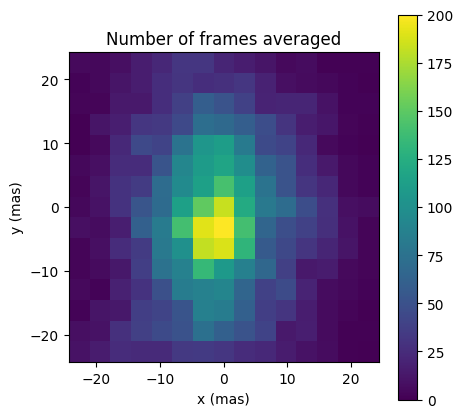

In [5]:
sd.bin_by_centroids(15, 3, calculate_variance = False)

Weird artifact is present (probably due to PSF splitting). Try frame selection

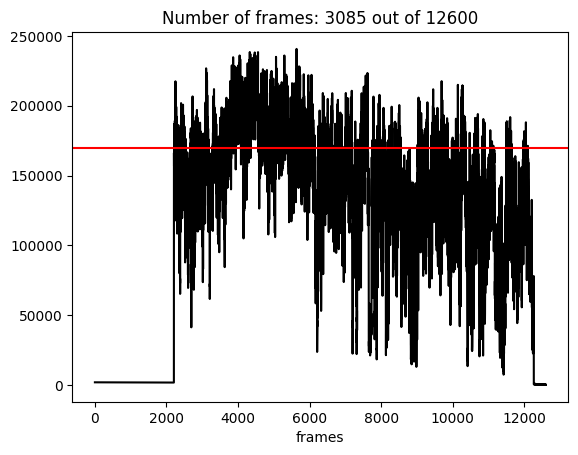

In [27]:
plt.plot(np.nanmax(sd.psfcam_frames, axis=(1,2)), color='black')
plt.xlabel('frames')

threshold = 170000
plt.axhline(threshold, color='red')

idx = np.nanmax(sd.psfcam_frames, axis=(1,2)) > threshold

plt.title(f'Number of frames: {np.sum(idx)} out of {len(idx)}')
plt.show()

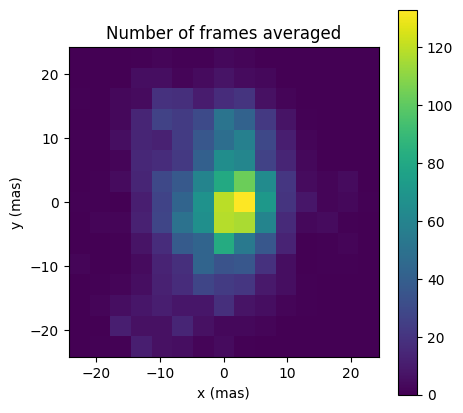

In [28]:
sd.bin_by_centroids(15, 3, effective_idx= idx,
                    calculate_variance = False)

There is definitely preferential jitter. Let's inspect how the couplingmaps look...

In [29]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

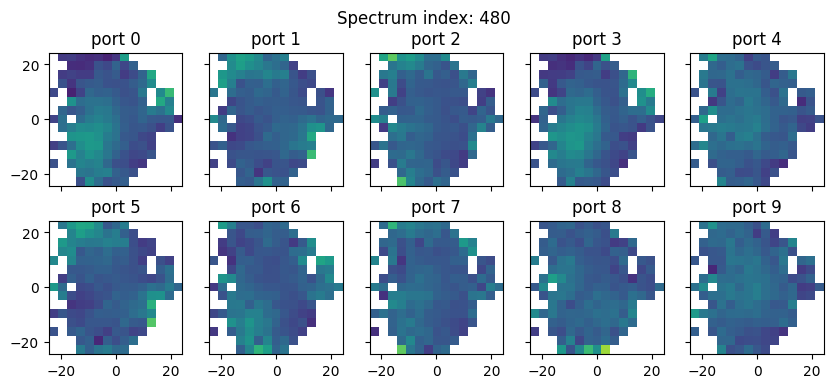

In [30]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(10,4), sharex=True, sharey=True)
axs = axs.flatten()

def animate(specind):
    for fibind in range(10):
        axs[fibind].clear()
        axs[fibind].imshow(sd.firstcam_binned_frames[:,:,fibind,specind] / np.nansum(sd.firstcam_binned_frames[:,:,fibind,specind]),
              vmin=0, vmax=0.02,
              extent = (sd.xmin, sd.xmax, sd.ymin, sd.ymax))
        axs[fibind].set_title('port %d' % fibind)
    fig.suptitle(f'Spectrum index: {specind}')

anim = FuncAnimation(fig, animate, frames = np.arange(480,520))
HTML(anim.to_jshtml())

/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


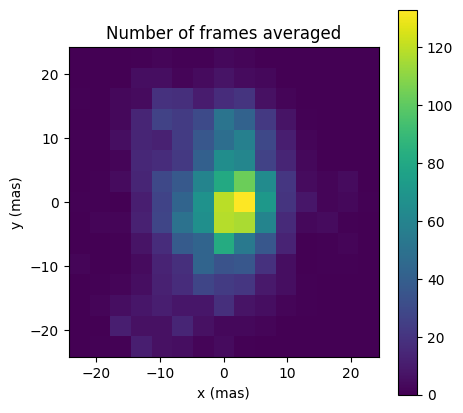

/home/first/yjkim/PLred/PLred/visPLred/couplingmap.py:57: RuntimeWarning: Mean of empty slice
  bootstrap_frames[k,i,j] = np.nanmean(firstcamframes[resampled_idx], axis = 0)
/home/first/yjkim/PLred/PLred/visPLred/couplingmap.py:64: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(bootstrap_frames, axis = 0)
/home/first/yjkim/PLred/PLred/visPLred/couplingmap.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice.
  normvar = np.nanvar(bootstrap_normframes, axis=0)


In [31]:
sd.bin_by_centroids(15, 3, effective_idx= idx, calculate_variance = True)


In [32]:
sd.save('betcmi_20241219_couplingmap.fits')
